In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import os
from torchvision import models, transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

In [2]:
resize = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor()
])

resize_np = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [3]:
def to_numpy(img):
    img = img.squeeze().detach().numpy() 
    return img.transpose(1,2,0) if len(img.shape) > 2 else img 

def to_image(img):
    if isinstance(img, torch.Tensor):
        img = np.uint8(255*to_numpy(img))
    return Image.fromarray(img)

def to_tensor(img):
    if isinstance(img, np.ndarray):
        return resize_np(img).unsqueeze(0).requires_grad_()
    return resize(img).unsqueeze(0).requires_grad_()
    
def show_im(img):
    if isinstance(img, (np.ndarray, torch.Tensor)):
        img = to_image(img)
    display(img)
    
def jitter(img, jitx, jity):
    return np.roll(np.roll(img, jitx, 0), jity, 1)

def octaver(img, num_octs, scale=1.2):
    octaves = [img]
    for octs in range(num_octs - 1):
        octaves.append(nd.zoom(octaves[-1], (1.0/scale, 1.0/scale,1)))
    return octaves

def rand_im(size=(224, 224, 3)):
    return np.uint8(np.random.uniform(150,180,size=size))

In [4]:
# MIT places dataset model
# pmodel = models.__dict__[arch](num_classes=365)
# checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
# state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
# pmodel.load_state_dict(state_dict)

In [5]:
def sub_module(layer):
    return nn.Sequential(*list(model.features.children())[:layer])

def visualize_layer(layer_index):
    sub_model = sub_module(layer_index)
    def func(img, filter_index):
        output = sub_model(img)
        images = to_numpy(output)
        if filter_index > 1:
            images = images[:,:,:filter_index].transpose(2,0,1)
        else:
            images = images[:,:,filter_index].squeeze()
        plot_imgs(images)
        plt.show()
    return func

def plot_imgs(imgs):
    size = int(np.sqrt(imgs.shape[0]))
    fig, axes = plt.subplots(size, size, figsize=(size,size))
    fig.subplots_adjust(wspace=0, hspace=0)
    inds = np.random.permutation(imgs.shape[0]).reshape(size, size)
    for i, row in zip(axes, inds):
        for j, col in zip(i, row):
            j.imshow(imgs[col])
            j.axis('off')
            j.set_aspect('auto')
    plt.show()

In [6]:
model = models.vgg19(pretrained=True).features

In [7]:
import copy

def preprocess_image(pil_im, jitx, jity, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im and not isinstance(pil_im, np.ndarray):
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Jitter the image
    im_as_arr = jitter(im_as_arr, jitx, jity)
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var, jitx, jity):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im)
    return jitter(recreated_im, -jitx, -jity).transpose(1, 2, 0)

def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


In [8]:
def visualise_layer(model, image, layer_ind, channel, iters, lr, jit=20, resize=False):
    # jitter the image
    jitx, jity = np.random.randint(-jit, jit+1, 2)
    
    # Process image and return variable
    processed_image = preprocess_image(image, jitx, jity, resize)
    # Define optimizer for the image
    optimizer = optim.Adam([processed_image], lr=lr, weight_decay=1e-6)
    for i in range(1, iters+1):
        optimizer.zero_grad()
        # Assign create image to a variable to move forward in the model
        x = processed_image
        for index, layer in enumerate(model.children()):
            # Forward pass layer by layer
            x = layer(x)
            if index == layer_ind:
                break
        # Backwards pass
        loss = -x[0, channel].mean()
        print('Iteration:{0:3d} Activation: {1:10.3f}'.format(i, -loss.data.numpy()))
        # Backward
        loss.backward()
        # Update image
        optimizer.step()
        # Recreate image
    return recreate_image(processed_image, jitx, jity)

In [9]:
img = Image.open('./images/dog.jpg')

Iteration:  1 Activation:      1.476
Iteration:  2 Activation:      5.507
Iteration:  3 Activation:     14.338
Iteration:  4 Activation:     23.337
Iteration:  5 Activation:     31.745
Iteration:  6 Activation:     39.660
Iteration:  7 Activation:     47.239
Iteration:  8 Activation:     54.574
Iteration:  9 Activation:     61.715
Iteration: 10 Activation:     68.721
Iteration: 11 Activation:     75.669
Iteration: 12 Activation:     82.556
Iteration: 13 Activation:     89.396
Iteration: 14 Activation:     96.213
Iteration: 15 Activation:    103.012


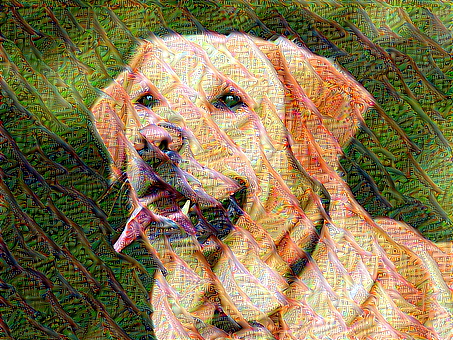

In [10]:
rim = rand_im((256,256,3))
im = visualise_layer(model, img, layer_ind=18, channel=50, iters=15, lr=0.1, jit=30, resize=True)
show_im(im)

In [11]:
save_image(im, '/images/high_frequency_dog.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '/images/high_frequency_dog.jpg'